In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from PIL import Image
import skimage.exposure
from skimage import img_as_float, img_as_uint
from torchvision.models.densenet import densenet121, densenet201
from torchvision.models.resnet import resnet34, resnet101, resnet152
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.densenet import densenet121, densenet201
from torchvision.models.resnet import resnet34, resnet50, resnet101, resnet152

import env
from utils import *
from utils import (KaggleCameraDataset, RNG, adjust_gamma, jpg_compress,
                   softmax, one_hot_decision_function, unhot)
# from main.run import CNN2
# from main.run_pretrained import DenseNet121, ResNet50

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
test = KaggleCameraDataset('../data/', train=False)

In [5]:
D = 1024
c = 512
for i in xrange(100):
    X = np.load(os.path.join('../data/', 'X_{0}.npy'.format(i)))
    X = X[:, D/2-c/2:D/2+c/2, D/2-c/2:D/2+c/2, :]
    np.save(os.path.join('../data/', 'X_{0}.npy'.format(i)), X)

In [15]:
def optical_crop(img, x1, y1, crop_size=512):
    """
    Depending on the position of the crop,
    rotate it so the the optical center of the camera is in bottom left:
    +--------+
    |        |
    | *      |
    | **     |
    | ***    |
    +--------+
    """
    w = img.size[0]
    h = img.size[1]
    img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
    if x1 + crop_size/2 < w/2: # center of crop is the left half
        if y1 + crop_size/2 < h/2: # top-left
            img = img.transpose(Image.ROTATE_270)
        else: # bottom-left
            img = img.transpose(Image.ROTATE_180)
    else: # center of crop is the right half
        if y1 + crop_size / 2 < h / 2:  # top-right
            pass
        else:  # bottom-right
            img = img.transpose(Image.ROTATE_90)
    return img

2750
<class 'PIL.JpegImagePlugin.JpegImageFile'>
5


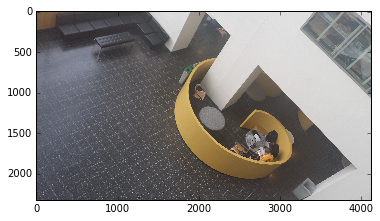

In [3]:
d = KaggleCameraDataset('../data', train=True)
print len(d)
X, y = d[1000]
print type(X)
print y
plt.imshow(X)

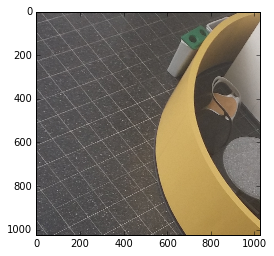

In [50]:
plt.imshow(Y)

In [9]:
Y = train_t(train_t(X))

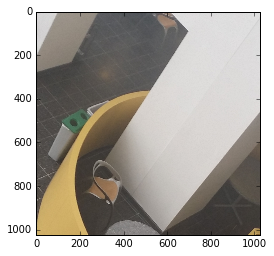

In [10]:
plt.imshow(Y)

In [11]:
rng = RNG(seed=1337)
def random_crop(img, crop_size, rng):
    x1 = rng.randint(img.size[0] - crop_size)
    y1 = rng.randint(img.size[1] - crop_size)
    return img.crop((x1, y1, x1 + crop_size, y1 + crop_size))

In [12]:
plt.imshow(random_crop(Y, 1024, rng))

ValueError: low >= high

In [14]:
rng.randint(1024-1024)

ValueError: low >= high

In [ ]:
plt.imshow(optical_crop(X, 3000, 1500))

In [4]:
rng = RNG()
train_t = transforms.Compose([
        transforms.RandomCrop(1024),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.Lambda(lambda img: [img,
#                                        img.transpose(Image.ROTATE_90)][int(rng.rand() < 0.5)]),
#         transforms.Lambda(lambda img: adjust_gamma(img, gamma=rng.uniform(0.8, 1.2))),
#         transforms.Lambda(lambda img: jpg_compress(img, quality=rng.randint(70, 100 + 1))),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [38]:
transforms.ToTensor()(X)


( 0  ,.,.) = 
  0.8078  0.7961  0.8039  ...   0.8392  0.8471  0.8549
  0.8078  0.8000  0.8039  ...   0.8431  0.8510  0.8588
  0.8118  0.8078  0.8078  ...   0.8510  0.8588  0.8549
           ...             ⋱             ...          
  0.2941  0.2863  0.2902  ...   0.7804  0.7686  0.7725
  0.3098  0.3137  0.3059  ...   0.7882  0.7804  0.7804
  0.3176  0.3176  0.3098  ...   0.7843  0.7804  0.7804

( 1  ,.,.) = 
  0.7255  0.7137  0.7216  ...   0.8392  0.8471  0.8549
  0.7255  0.7176  0.7255  ...   0.8431  0.8510  0.8588
  0.7412  0.7373  0.7373  ...   0.8510  0.8588  0.8549
           ...             ⋱             ...          
  0.2863  0.2784  0.2824  ...   0.7804  0.7686  0.7725
  0.2980  0.3020  0.2941  ...   0.7882  0.7804  0.7804
  0.3098  0.3098  0.3020  ...   0.7843  0.7804  0.7804

( 2  ,.,.) = 
  0.6431  0.6314  0.6392  ...   0.8392  0.8471  0.8549
  0.6431  0.6353  0.6314  ...   0.8431  0.8510  0.8588
  0.6471  0.6431  0.6431  ...   0.8510  0.8588  0.8549
           ...      

In [39]:

def center_crop(img, crop_size):
    w = img.size[0]
    h = img.size[1]
    return img.crop((w / 2 - crop_size / 2, h / 2 - crop_size / 2,
                     w / 2 + crop_size / 2, h / 2 + crop_size / 2))

crop_size = 512
def interp(img, ratio='0.5'):
    """
    Parameters
    ----------
    img : (1024, 1024) PIL image
    ratio : {'0.5', '0.8', '1.5', '2.0'}

    Returns
    -------
    img_interp : (args.crop_size, args.crop_size) PIL image
    """
    if ratio == '0.5':
        img = center_crop(img, 2 * crop_size)
    elif ratio == '0.8':
        img = center_crop(img, int(crop_size * 1.25 + 1))
    elif ratio == '1.5':
        img = center_crop(img, int(crop_size * 2 / 3 + 1))
    elif ratio == '2.0':
        img = center_crop(img, crop_size / 2)
    return img.resize((crop_size, crop_size), Image.BICUBIC)

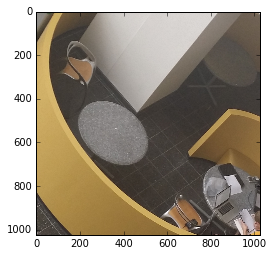

In [40]:
plt.imshow(X_crop)

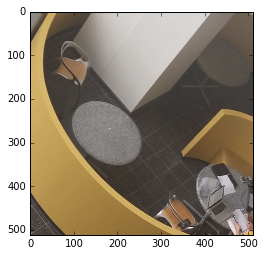

In [44]:
plt.imshow(interp(X_crop, ratio='1.'))

In [16]:
def tta(img, f, n=8):
    out = [img]
    for _ in xrange(n):
        out.append(f(img))
    return out
    
tta_t = transforms.Compose([
    transforms.Lambda(lambda img: tta(img, train_t)),
])

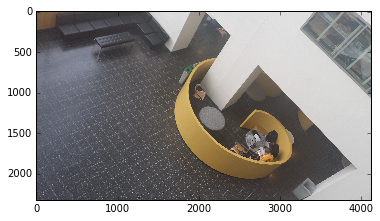

In [19]:
out = tta_t(X)
plt.imshow(out[0])

In [ ]:
plt.imshow(out[1])
plt.imshow(out[2])

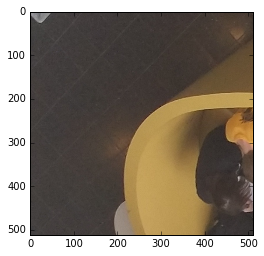

In [21]:
x = train_t(X)
plt.imshow(x)

### Laplace stuff

In [22]:
import cv2

In [25]:
x = np.array(x)
x -= cv2.GaussianBlur(x, (3,3), 0)

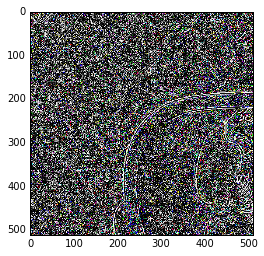

In [26]:
plt.imshow(x)

In [30]:
y = x.astype(np.float32) / 255.
z = np.stack([np.abs( np.fft.fftshift(np.fft.fft2(y[:,:,c])) ) for c in range(3)], axis=-1)

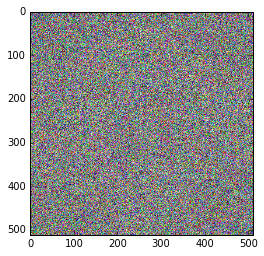

In [32]:
plt.imshow(np.log(z))

In [33]:
np.log(z).max()/=12.*250

11.278731127443903

 ### Dense-Net (121)

In [20]:
net = densenet121(pretrained=True)

In [45]:
inp = Variable(torch.randn(1, 3, 256, 256))
features = nn.Sequential(*list(net.children())[:-1])
out = features(inp)
print out.size()

torch.Size([1, 1024, 8, 8])


In [49]:
F.avg_pool2d(out, kernel_size=5).size()

torch.Size([1, 1024, 1, 1])

In [19]:
Z = [np.random.rand(2630, 10), np.random.rand(5, 10), np.random.rand(5, 10)]
Z = np.vstack(Z)
P = softmax(Z)
P.shape

(2640, 10)

In [33]:
P = .01 * (np.arange(24) ** 2).reshape((8, 3))
P = softmax(P)
P

array([[ 0.32777633,  0.33107054,  0.34115313],
       [ 0.30806966,  0.33040724,  0.3615231 ],
       [ 0.28885386,  0.32895498,  0.38219116],
       [ 0.27019182,  0.32672935,  0.40307883],
       [ 0.25213984,  0.32375397,  0.42410619],
       [ 0.23474696,  0.32005991,  0.44519313],
       [ 0.21805443,  0.31568495,  0.46626061],
       [ 0.20209544,  0.31067273,  0.48723183]])

In [50]:
P.reshape(len(P)/4, 4, -1).mean(axis=1)

array([[ 0.29872292,  0.32929052,  0.37198656],
       [ 0.22675917,  0.31754289,  0.45569794]])

In [21]:
unhot(one_hot_decision_function(P)).astype(int)

array([8, 5, 3, ..., 2, 2, 5])

In [22]:
test_dataset = CameraDataset('../data/', train=False, lazy=True)

In [23]:
d = {'fname': [os.path.split(fname)[-1] for fname in test_dataset.X], 
     'camera': [CameraDataset.target_labels()[int(c)] for c in unhot(one_hot_decision_function(P))]}

In [18]:
len(d['fname'])

2640

In [31]:
df = pd.DataFrame(d, columns=['fname', 'camera'])

In [27]:
df.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-4s
1,img_001e31c_unalt.tif,Samsung-Galaxy-Note3
2,img_00275cf_manip.tif,Motorola-Nexus-6
3,img_0034113_unalt.tif,Motorola-X
4,img_00344b7_unalt.tif,Motorola-Nexus-6


In [33]:
df.to_csv('submission.csv', index=False)

In [32]:
df.to_csv?

In [36]:
df = pd.DataFrame(P)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.143422,0.117828,0.084925,0.070435,0.074870,0.110303,0.084986,0.093199,0.145830,0.074203
1,0.094594,0.069089,0.092454,0.093395,0.147770,0.148159,0.096315,0.056855,0.069810,0.131558
2,0.094094,0.074771,0.121133,0.141500,0.074345,0.108733,0.122552,0.089606,0.076543,0.096724
3,0.101315,0.067996,0.103423,0.085651,0.154970,0.078481,0.073201,0.066494,0.124009,0.144460
4,0.061450,0.069962,0.121857,0.153979,0.137479,0.098404,0.082526,0.122796,0.066677,0.084870


In [37]:
df['fname'] = d['fname']

In [43]:
df = df[['fname'] + range(10)]

In [44]:
df.to_csv('proba.csv', index=False)

### small CNN

In [8]:
feats = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.ReLU(inplace=True),
)
classifier = nn.Sequential(
    nn.Linear(512, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10),
)
inp = Variable(torch.randn(1, 3, 64, 64))
feats(inp).size()

torch.Size([1, 128, 1, 1])

In [28]:
for layer in feats.modules():
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform(layer.weight.data)

for layer in classifier.modules():
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform(layer.weight.data)

In [35]:
T = torch.from_numpy(np.arange(2*3*4*5).reshape((2,3,4,5)))

In [36]:
T


(0 ,0 ,.,.) = 
    0    1    2    3    4
    5    6    7    8    9
   10   11   12   13   14
   15   16   17   18   19

(0 ,1 ,.,.) = 
   20   21   22   23   24
   25   26   27   28   29
   30   31   32   33   34
   35   36   37   38   39

(0 ,2 ,.,.) = 
   40   41   42   43   44
   45   46   47   48   49
   50   51   52   53   54
   55   56   57   58   59

(1 ,0 ,.,.) = 
   60   61   62   63   64
   65   66   67   68   69
   70   71   72   73   74
   75   76   77   78   79

(1 ,1 ,.,.) = 
   80   81   82   83   84
   85   86   87   88   89
   90   91   92   93   94
   95   96   97   98   99

(1 ,2 ,.,.) = 
  100  101  102  103  104
  105  106  107  108  109
  110  111  112  113  114
  115  116  117  118  119
[torch.LongTensor of size 2x3x4x5]

In [37]:
T.view(2 * 3, 4, 5)


(0 ,.,.) = 
    0    1    2    3    4
    5    6    7    8    9
   10   11   12   13   14
   15   16   17   18   19

(1 ,.,.) = 
   20   21   22   23   24
   25   26   27   28   29
   30   31   32   33   34
   35   36   37   38   39

(2 ,.,.) = 
   40   41   42   43   44
   45   46   47   48   49
   50   51   52   53   54
   55   56   57   58   59

(3 ,.,.) = 
   60   61   62   63   64
   65   66   67   68   69
   70   71   72   73   74
   75   76   77   78   79

(4 ,.,.) = 
   80   81   82   83   84
   85   86   87   88   89
   90   91   92   93   94
   95   96   97   98   99

(5 ,.,.) = 
  100  101  102  103  104
  105  106  107  108  109
  110  111  112  113  114
  115  116  117  118  119
[torch.LongTensor of size 6x4x5]

In [34]:
y = torch.from_numpy(np.asarray([0, 1]))
torch.from_numpy(y.numpy().repeat(3))


 0
 0
 0
 1
 1
 1
[torch.LongTensor of size 6]

In [2]:
d = DenseNet121()
inp = Variable(torch.randn(1, 3, 256, 256))
out = d.features(inp)
out.size()

torch.Size([1, 1024, 8, 8])

In [7]:
F.avg_pool2d(out, kernel_size=7).size()

torch.Size([1, 1024, 1, 1])

In [16]:
m = resnet34(pretrained=True)
feats = nn.Sequential(*list(m.children())[:-1])
inp = Variable(torch.randn(1, 3, 256, 256))
out = feats(inp)
out.size()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/monsta/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 68567383.57it/s]


torch.Size([1, 512, 2, 2])

In [82]:
feats=nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=96, kernel_size=7, stride=1),
    nn.BatchNorm2d(num_features=96),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=96, out_channels=128, kernel_size=5, stride=1),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
#     nn.BatchNorm2d(num_features=512),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1),
#     nn.BatchNorm2d(num_features=1024),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=2, stride=2),
)
inp = Variable(torch.randn(1, 3, 128, 128))
out = feats(inp)
out.size()

torch.Size([1, 512, 1, 1])

In [11]:
X = np.asarray(X, dtype=np.float32)
X /= 255.

In [6]:
import cv2

In [7]:
K = 1/12. * np.array([[-1,  2,  -2,  2, -1],
                      [ 2, -6,   8, -6,  2],
                      [-2,  8, -12,  8, -2],
                      [ 2, -6,   8, -6,  2],
                      [-1,  2,  -2,  2, -1]])

In [12]:
Y = cv2.filter2D(X, -1, K)

In [13]:
Y.max()

0.25718954

In [14]:
Z = (Y * 255.).astype(np.uint8)

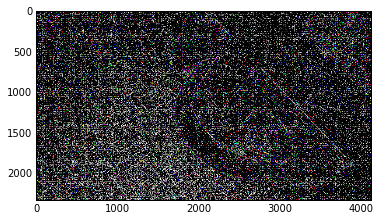

In [15]:
plt.imshow(Z)

In [16]:
import scipy.ndimage.filters

In [25]:
Y = np.zeros_like(X)
Y[:,:,0] = scipy.ndimage.filters.convolve(X[:,:,0], K)
Y[:,:,1] = scipy.ndimage.filters.convolve(X[:,:,1], K)
Y[:,:,2] = scipy.ndimage.filters.convolve(X[:,:,2], K)
Y.shape

(2322, 4128, 3)

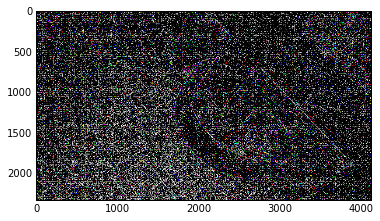

In [26]:
plt.imshow(Y)

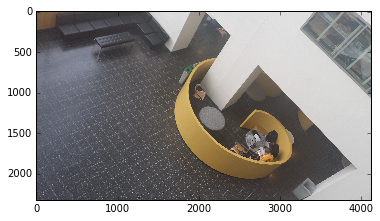

In [22]:
plt.imshow(X)

In [28]:
Y.max()

0.25718951

In [29]:
T = torch.from_numpy(Y)

In [2]:
m = 1e-3
M = 6e-3
s = 27
epoch = np.arange(8 * 27)
cycle = np.floor(1. + 0.5*epoch/float(s))
x = np.abs(epoch/float(s)-2.*cycle+1.)
y = m + (M-m)*(1.-x)

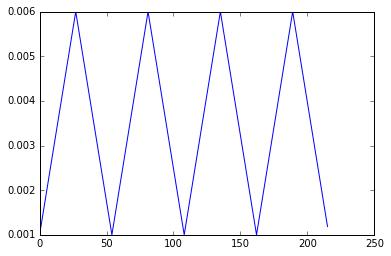

In [3]:
plt.plot(y)

In [5]:
z = y[1:] / y[:-1]
z[:10]

array([ 1.18518519,  1.15625   ,  1.13513514,  1.11904762,  1.10638298,
        1.09615385,  1.0877193 ,  1.08064516,  1.07462687,  1.06944444])

In [8]:
m = resnet34(pretrained=True)
feats = nn.Sequential(*list(m.children())[:-2])
inp = Variable(torch.randn(1, 3, 128, 128))
out = feats(inp)
out.size()

torch.Size([1, 512, 4, 4])

In [9]:
F.avg_pool2d(out, kernel_size=2).size()

torch.Size([1, 512, 2, 2])

In [10]:
m = densenet201(pretrained=True)
feats = nn.Sequential(*list(m.children())[:-1])
inp = Variable(torch.randn(1, 3, 256, 256))
out = feats(inp)
out.size()

torch.Size([1, 1920, 8, 8])

In [14]:
F.avg_pool2d(out, kernel_size=5).size()

torch.Size([1, 1920, 1, 1])

In [10]:
r = ResNet50()

In [2]:
orig_model = resnet50(pretrained=True)
features = nn.Sequential(*list(orig_model.children())[:-3])

In [3]:
features(inp).size()

NameError: name 'inp' is not defined

In [4]:
inp = Variable(torch.randn(1, 3, 256, 256))
out = features(inp)

In [5]:
clf = nn.Sequential(
    nn.Linear(2*1024, 1024),
    nn.PReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 256),
    nn.PReLU(),
)
clf2 = nn.Sequential(
    nn.Linear(256 + 32, 10)
)
inp = Variable(torch.randn(5, 2048))
out = clf(inp)
out.size()

torch.Size([5, 256])

In [6]:
F.avg_pool2d(out, kernel_size=16).size()

torch.Size([1, 1024, 1, 1])

In [15]:
from main.models import ResNext101_32

In [4]:
m = resnext101_32x4d()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/resnext101_32x4d-29e315fa.pth" to /home/monsta/.torch/models/resnext101_32x4d-29e315fa.pth
100%|██████████| 177332805/177332805 [03:14<00:00, 913573.85it/s] 


In [18]:
from utils import float32

In [19]:
inp = Variable(torch.randn(1, 3, 256, 256))
out = ResNext101_32()((inp, float32(0.)))

RuntimeError: expected Variable as element 1 in argument 0, but got tuple

In [7]:
out.size()

torch.Size([1, 2048, 8, 8])

In [9]:
resnext101_32x4d.__name__

'resnext101_32x4d'

In [4]:
m = float32(0.)

In [8]:
torch.from_numpy([m] * 10).size()

RuntimeError: from_numpy expects an np.ndarray but got list

In [18]:
seed = 1337
seed = 42 * seed + 1337
N_BLOCKS = [21, 16, 16, 17, 12, 19, 31, 16, 31, 23]
N_IMAGES_PER_BLOCK = [
    [51, 51, 51, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
    [49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 47, 47, 47, 47, 47, 47],
    [50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 48],
    [50, 50, 50, 50, 50, 50, 50, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48],
    [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 51],
    [51, 51, 51, 51, 51, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
    [50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48],
    [52, 52, 52, 52, 52, 52, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50],
    [49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 47, 47, 47, 47, 47, 47, 47],
    [49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
]


In [19]:
for c in xrange(10):
    b_ind.append([])
    for b in xrange(N_BLOCKS[c]):
        N = N_IMAGES_PER_BLOCK[c][b]
        b_ind[c] += [RNG(seed + 101 * c + b).choice(range(N), N).tolist()]

In [10]:
batch_size = 5
nb_digits = 10
y = torch.LongTensor(batch_size,1).random_() % nb_digits
y_onehot = torch.FloatTensor(batch_size, nb_digits)
y_onehot.zero_()
y_onehot.scatter_(1, y, 1)

print(y)
print(y_onehot)
print torch.FloatTensor(batch_size, nb_digits).zero_().scatter_(1, y, 1)


 4
 8
 6
 5
 9
[torch.LongTensor of size 5x1]


    0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     1     0     0     0
    0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
[torch.FloatTensor of size 5x10]


    0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     1     0     0     0
    0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
[torch.FloatTensor of size 5x10]



In [12]:
logits_train = np.vstack((np.load('../data/soft/logits_train.npy'), np.load('../data/soft/logits_train222222.npy')))
np.save('../data/logits_train.npy', logits_train)

In [13]:
manip_train = np.vstack((np.load('../data/soft/manip_train.npy'), np.load('../data/soft/manip_train222222.npy')))
sum(manip_train)

array([ 974.], dtype=float32)

In [15]:
N_BLOCKS = [21, 14, 16, 16, 12, 18, 31, 16, 18, 22]
N_IMAGES_PER_BLOCK = [
    [48, 48, 48, 48, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47],
    [47, 47, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46],
    [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47],
    [49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48],
    [50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49],
    [49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48],
    [49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48],
    [47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 46],
    [50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
    [49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
]

In [36]:
softmax(logits_train[1]/7.).tolist()

[[0.44740218066454657,
  0.056567357503434626,
  0.0845993716930428,
  0.060803111333955676,
  0.06751871570067235,
  0.054271179190445225,
  0.05072142140238208,
  0.07131834809866444,
  0.05091160513301597,
  0.0558867092798405]]

In [2]:
T = torch.from_numpy(np.random.rand(4, 3))
T


 0.6121  0.5110  0.0910
 0.4625  0.9363  0.7740
 0.3376  0.2522  0.2466
 0.9003  0.6648  0.9976
[torch.DoubleTensor of size 4x3]

In [8]:
T.mean(1).view(-1, 1)


1.00000e-16 *
  0.0000
 -0.7401
  0.1850
 -1.1102
[torch.DoubleTensor of size 4x1]

In [7]:
T


 0.2074  0.1063 -0.3137
-0.2618  0.2121  0.0497
 0.0588 -0.0266 -0.0322
 0.0461 -0.1894  0.1434
[torch.DoubleTensor of size 4x3]